In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

/Users/yujian/.pyenv/versions/3.10.1/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/yujian/.pyenv/versions/3.10.1/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: /Users/yujian/.pyenv/versions/3.10.1/lib/python3.10/site-packages/torchvision/image.so
  Expected in: /Users/yujian/.pyenv/versions/3.10.1/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # self.flatten = nn.Flatten()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3), # 28 x 28 --> 26 x 26 x 4
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1), # 26 x 26 x 4 
            nn.Flatten(), # --> (26 x 26 x 4)
            nn.Linear(26*26*4, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, X):
        # x = self.flatten(X)
        logits = self.cnn(X)
        return logits

model = NeuralNetwork()
learning_rate = 1e-3
batch_size=64
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [3]:
training_data = datasets.FashionMNIST(root="../../fashion_mnist", train=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root="../../fashion_mnist", train=False, transform=transforms.ToTensor())

In [4]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [5]:
kfold_validator = KFold(n_splits=5, shuffle=True, random_state=42)

In [6]:
def train_loop(dataloader, model, loss_fn, _optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # predictions
        pred = model(X)
        loss = loss_fn(pred, y)

        # backprop
        _optimizer.zero_grad()
        loss.backward()
        _optimizer.step()

        if batch%100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Current loss: {loss:>7f}, [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")
    return 100*correct

In [12]:
def optimize_loop(epoch_list, accuracy_list, epochs, train_dl, test_dl, _model, _optimizer):
    for t in range(epochs):
        print(f"Epoch {t+1}\n")
        train_loop(train_dl, _model, loss_fn, _optimizer)
        accuracy = test_loop(test_dl, _model, loss_fn)
        epoch_list.append(t)
        accuracy_list.append(accuracy)
    print("Done!")

In [15]:
def kfold_train_validate():
    for fold, (training_indices, validation_indices) in enumerate(kfold_validator.split(training_data)):
        subsampled_training_data = torch.utils.data.Subset(training_data, training_indices)
        subsampled_validation_data = torch.utils.data.Subset(training_data, validation_indices)
        train_dataloader = torch.utils.data.DataLoader(subsampled_training_data, batch_size=64)
        validation_dataloader = torch.utils.data.DataLoader(subsampled_validation_data, batch_size=64)
        plot_x = [] # epoch
        plot_y = [] # accuracy
        model = NeuralNetwork()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        optimize_loop(plot_x, plot_y, 5, train_dataloader, validation_dataloader, model, optimizer)
        torch.save(model.state_dict(),f'./fashion-mnist-cnn-fold-{fold}.pt')
        plt.plot(plot_x, plot_y)
        plt.savefig(f"fold-{fold}-accuracy.png")
        plt.show()

Epoch 1

Current loss: 2.304149, [    0/48000]
Current loss: 2.285671, [ 6400/48000]
Current loss: 2.266409, [12800/48000]
Current loss: 2.242792, [19200/48000]
Current loss: 2.192669, [25600/48000]
Current loss: 2.136933, [32000/48000]
Current loss: 2.103998, [38400/48000]
Current loss: 2.033402, [44800/48000]
Test Error:
 Accuracy: 46.1%, Avg loss: 2.006167

Epoch 2

Current loss: 2.002770, [    0/48000]
Current loss: 1.916237, [ 6400/48000]
Current loss: 1.852235, [12800/48000]
Current loss: 1.690590, [19200/48000]
Current loss: 1.473769, [25600/48000]
Current loss: 1.345888, [32000/48000]
Current loss: 1.264078, [38400/48000]
Current loss: 1.260361, [44800/48000]
Test Error:
 Accuracy: 66.6%, Avg loss: 1.162495

Epoch 3

Current loss: 1.176998, [    0/48000]
Current loss: 1.090460, [ 6400/48000]
Current loss: 1.111719, [12800/48000]
Current loss: 1.025241, [19200/48000]
Current loss: 0.831240, [25600/48000]
Current loss: 0.827148, [32000/48000]
Current loss: 0.817091, [38400/48000]

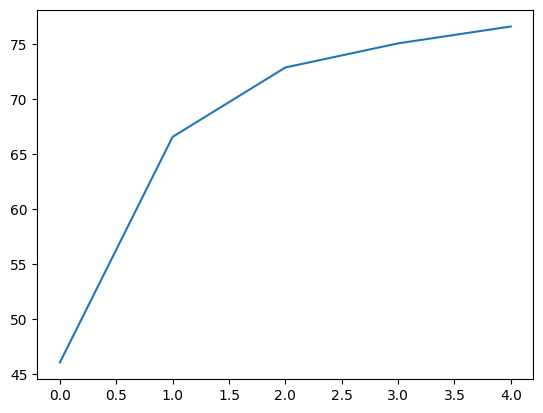

Epoch 1

Current loss: 2.320345, [    0/48000]
Current loss: 2.295456, [ 6400/48000]
Current loss: 2.281255, [12800/48000]
Current loss: 2.247634, [19200/48000]
Current loss: 2.240787, [25600/48000]
Current loss: 2.213397, [32000/48000]
Current loss: 2.165635, [38400/48000]
Current loss: 2.114762, [44800/48000]
Test Error:
 Accuracy: 57.2%, Avg loss: 2.074713

Epoch 2

Current loss: 2.093210, [    0/48000]
Current loss: 1.983829, [ 6400/48000]
Current loss: 1.850408, [12800/48000]
Current loss: 1.757871, [19200/48000]
Current loss: 1.632211, [25600/48000]
Current loss: 1.511351, [32000/48000]
Current loss: 1.327158, [38400/48000]
Current loss: 1.316284, [44800/48000]
Test Error:
 Accuracy: 65.4%, Avg loss: 1.235924

Epoch 3

Current loss: 1.342437, [    0/48000]
Current loss: 1.078666, [ 6400/48000]
Current loss: 0.996005, [12800/48000]
Current loss: 0.970019, [19200/48000]
Current loss: 0.895947, [25600/48000]
Current loss: 0.965447, [32000/48000]
Current loss: 0.800323, [38400/48000]

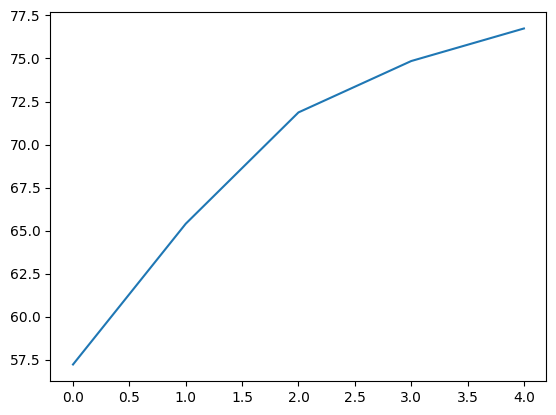

Epoch 1

Current loss: 2.290048, [    0/48000]
Current loss: 2.274190, [ 6400/48000]
Current loss: 2.229176, [12800/48000]
Current loss: 2.200330, [19200/48000]
Current loss: 2.145529, [25600/48000]
Current loss: 2.081069, [32000/48000]
Current loss: 1.990045, [38400/48000]
Current loss: 1.940860, [44800/48000]
Test Error:
 Accuracy: 59.9%, Avg loss: 1.839295

Epoch 2

Current loss: 1.889769, [    0/48000]
Current loss: 1.730854, [ 6400/48000]
Current loss: 1.608210, [12800/48000]
Current loss: 1.399026, [19200/48000]
Current loss: 1.305581, [25600/48000]
Current loss: 1.161732, [32000/48000]
Current loss: 1.071079, [38400/48000]
Current loss: 1.149166, [44800/48000]
Test Error:
 Accuracy: 69.6%, Avg loss: 1.026772

Epoch 3

Current loss: 1.069262, [    0/48000]
Current loss: 1.061180, [ 6400/48000]
Current loss: 1.011635, [12800/48000]
Current loss: 0.809640, [19200/48000]
Current loss: 0.788827, [25600/48000]
Current loss: 0.751986, [32000/48000]
Current loss: 0.727385, [38400/48000]

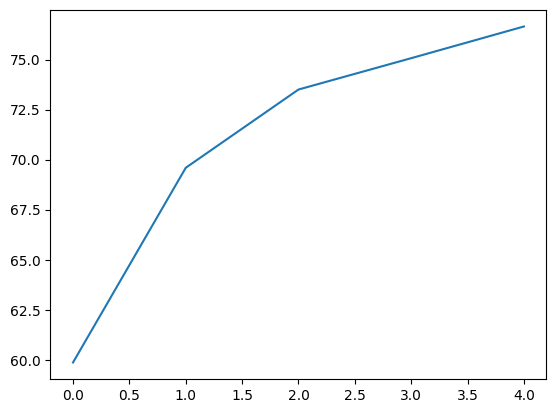

Epoch 1

Current loss: 2.272742, [    0/48000]
Current loss: 2.268548, [ 6400/48000]
Current loss: 2.233164, [12800/48000]
Current loss: 2.178007, [19200/48000]
Current loss: 2.088535, [25600/48000]
Current loss: 2.013281, [32000/48000]
Current loss: 1.906849, [38400/48000]
Current loss: 1.832794, [44800/48000]
Test Error:
 Accuracy: 58.1%, Avg loss: 1.747328

Epoch 2

Current loss: 1.748411, [    0/48000]
Current loss: 1.693891, [ 6400/48000]
Current loss: 1.565691, [12800/48000]
Current loss: 1.479265, [19200/48000]
Current loss: 1.259079, [25600/48000]
Current loss: 1.140180, [32000/48000]
Current loss: 1.027853, [38400/48000]
Current loss: 1.159021, [44800/48000]
Test Error:
 Accuracy: 71.2%, Avg loss: 0.987952

Epoch 3

Current loss: 0.963503, [    0/48000]
Current loss: 1.100421, [ 6400/48000]
Current loss: 0.981420, [12800/48000]
Current loss: 1.107087, [19200/48000]
Current loss: 0.857808, [25600/48000]
Current loss: 0.783782, [32000/48000]
Current loss: 0.726121, [38400/48000]

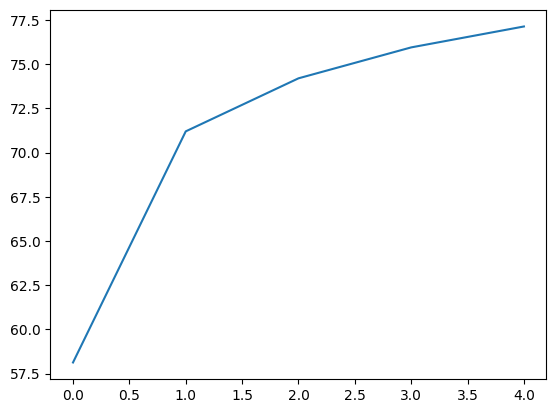

Epoch 1

Current loss: 2.307073, [    0/48000]
Current loss: 2.296359, [ 6400/48000]
Current loss: 2.289688, [12800/48000]
Current loss: 2.277036, [19200/48000]
Current loss: 2.246934, [25600/48000]
Current loss: 2.244156, [32000/48000]
Current loss: 2.226875, [38400/48000]
Current loss: 2.216159, [44800/48000]
Test Error:
 Accuracy: 41.2%, Avg loss: 2.183395

Epoch 2

Current loss: 2.183250, [    0/48000]
Current loss: 2.140383, [ 6400/48000]
Current loss: 2.102598, [12800/48000]
Current loss: 2.024657, [19200/48000]
Current loss: 1.924389, [25600/48000]
Current loss: 1.877236, [32000/48000]
Current loss: 1.681841, [38400/48000]
Current loss: 1.670603, [44800/48000]
Test Error:
 Accuracy: 61.8%, Avg loss: 1.521744

Epoch 3

Current loss: 1.560077, [    0/48000]
Current loss: 1.361090, [ 6400/48000]
Current loss: 1.264357, [12800/48000]
Current loss: 1.081871, [19200/48000]
Current loss: 1.059610, [25600/48000]
Current loss: 1.152953, [32000/48000]
Current loss: 0.917216, [38400/48000]

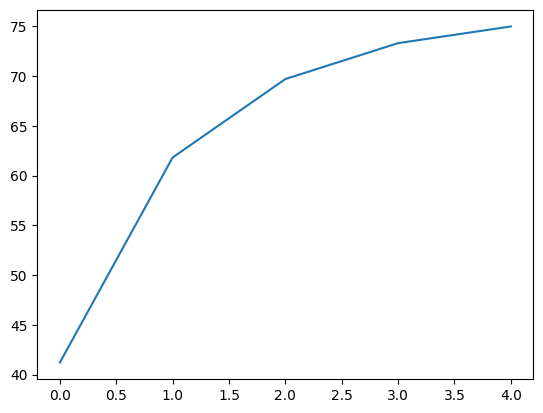

In [16]:
kfold_train_validate()